<a href="https://colab.research.google.com/github/madan20maccccc/ICN-TEAM-20/blob/main/Team_20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np

# -----------------------------
# Load dataset
# -----------------------------
df = pd.read_csv("multi_criteria_routing_data.csv")

print("Initial shape:", df.shape)

# -----------------------------
# 1. Check missing values
# -----------------------------
print("\nMissing values per column:")
print(df.isnull().sum())

# -----------------------------
# 2. Remove duplicates (if any)
# -----------------------------
df = df.drop_duplicates()
print("\nShape after removing duplicates:", df.shape)

# -----------------------------
# 3. Remove invalid routing entries
#    (negative or zero values where not logical)
# -----------------------------
numeric_cols = [
    "Latency_ms",
    "Bandwidth_Mbps",
    "Energy_Consumption_J",
    "Packet_Delivery_Ratio_%",
    "End_to_End_Delay_ms",
    "Trust_Score"
]

for col in numeric_cols:
    df = df[df[col] > 0]

print("\nShape after removing invalid values:", df.shape)

# -----------------------------
# 4. Normalize key routing metrics
#    (important for DRL stability)
# -----------------------------
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

features_to_scale = [
    "Latency_ms",
    "Bandwidth_Mbps",
    "Security_Risk",
    "Energy_Consumption_J",
    "Packet_Delivery_Ratio_%",
    "End_to_End_Delay_ms",
    "Trust_Score"
]

df_scaled = df.copy()
df_scaled[features_to_scale] = scaler.fit_transform(df[features_to_scale])

print("\nScaled data preview:")
print(df_scaled[features_to_scale].head())

# -----------------------------
# Final cleaned dataset
# -----------------------------
print("\nFinal cleaned dataset shape:", df_scaled.shape)


Initial shape: (500, 12)

Missing values per column:
Route_ID                   0
Source_Node                0
Destination_Node           0
Latency_ms                 0
Bandwidth_Mbps             0
Security_Risk              0
Energy_Consumption_J       0
Packet_Delivery_Ratio_%    0
End_to_End_Delay_ms        0
Trust_Score                0
Algorithm_Used             0
Optimal                    0
dtype: int64

Shape after removing duplicates: (500, 12)

Shape after removing invalid values: (500, 12)

Scaled data preview:
   Latency_ms  Bandwidth_Mbps  Security_Risk  Energy_Consumption_J  \
0    0.266612        0.177015       0.212630              0.847430   
1    0.643049        0.854165       0.505915              0.693964   
2    0.405778        0.490046       0.841847              0.430793   
3    0.019162        0.243637       0.733597              0.674392   
4    0.151043        0.870621       0.542417              0.275885   

   Packet_Delivery_Ratio_%  End_to_End_Delay_ms  Tr

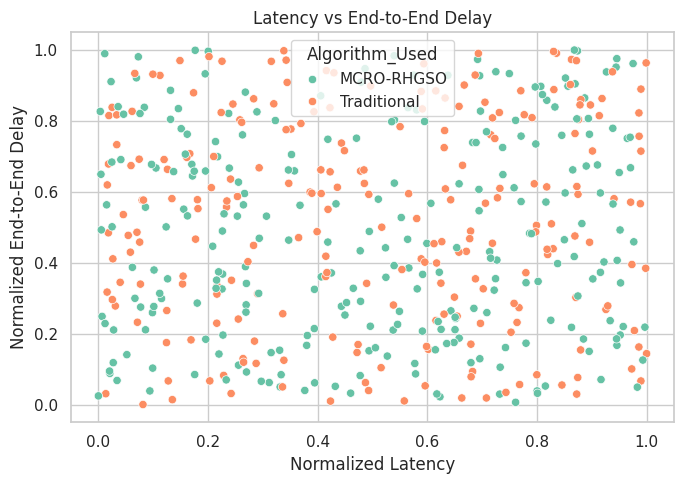

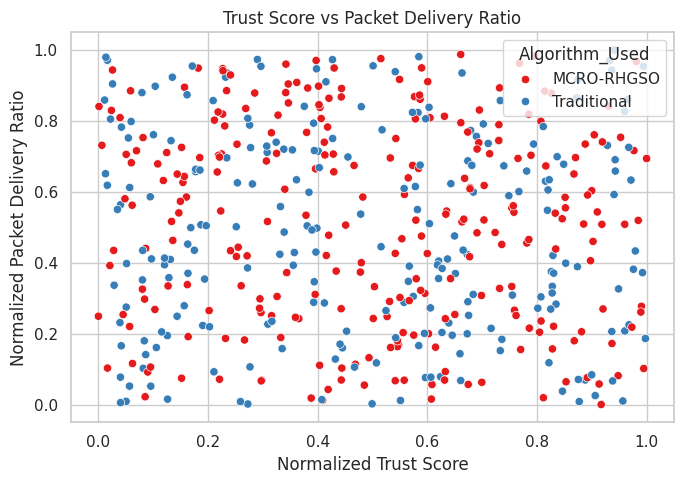

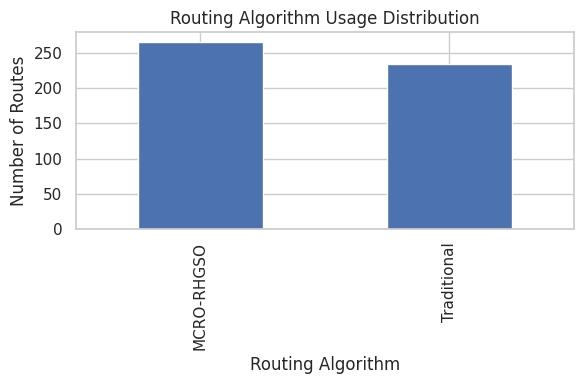

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

# -----------------------------
# 1. Latency vs End-to-End Delay
# -----------------------------
plt.figure(figsize=(7,5))
sns.scatterplot(
    data=df_scaled,
    x="Latency_ms",
    y="End_to_End_Delay_ms",
    hue="Algorithm_Used",
    palette="Set2"
)
plt.title("Latency vs End-to-End Delay")
plt.xlabel("Normalized Latency")
plt.ylabel("Normalized End-to-End Delay")
plt.tight_layout()
plt.show()

# -----------------------------
# 2. Trust vs Packet Delivery
# -----------------------------
plt.figure(figsize=(7,5))
sns.scatterplot(
    data=df_scaled,
    x="Trust_Score",
    y="Packet_Delivery_Ratio_%",
    hue="Algorithm_Used",
    palette="Set1"
)
plt.title("Trust Score vs Packet Delivery Ratio")
plt.xlabel("Normalized Trust Score")
plt.ylabel("Normalized Packet Delivery Ratio")
plt.tight_layout()
plt.show()

# -----------------------------
# 3. Routing Algorithm Usage
# -----------------------------
plt.figure(figsize=(6,4))
df["Algorithm_Used"].value_counts().plot(kind="bar")
plt.title("Routing Algorithm Usage Distribution")
plt.xlabel("Routing Algorithm")
plt.ylabel("Number of Routes")
plt.tight_layout()
plt.show()


In [ ]:
# -----------------------------
# BLOCK 3: Baseline Routing Cost
# -----------------------------

# We define a traditional routing cost
# Lower cost = better route

df_baseline = df_scaled.copy()

df_baseline["Routing_Cost"] = (
    0.4 * df_baseline["Latency_ms"] +
    0.3 * df_baseline["End_to_End_Delay_ms"] +
    0.2 * df_baseline["Energy_Consumption_J"] -
    0.1 * df_baseline["Trust_Score"]
)

print("Baseline routing cost preview:")
print(df_baseline[[
    "Latency_ms",
    "End_to_End_Delay_ms",
    "Energy_Consumption_J",
    "Trust_Score",
    "Routing_Cost"
]].head())

# -----------------------------
# Best route chosen by baseline
# -----------------------------
best_baseline_route = df_baseline.loc[df_baseline["Routing_Cost"].idxmin()]

print("\nBest route selected by traditional routing:")
print(best_baseline_route)


Baseline routing cost preview:
   Latency_ms  End_to_End_Delay_ms  Energy_Consumption_J  Trust_Score  \
0    0.266612             0.595302              0.847430     0.182164   
1    0.643049             0.264271              0.693964     0.157140   
2    0.405778             0.662041              0.430793     0.829163   
3    0.019162             0.815180              0.674392     0.041980   
4    0.151043             0.778225              0.275885     0.420111   

   Routing_Cost  
0      0.436505  
1      0.459580  
2      0.364166  
3      0.382899  
4      0.307051  

Best route selected by traditional routing:
Route_ID                          R256
Source_Node                         13
Destination_Node                    29
Latency_ms                    0.081288
Bandwidth_Mbps                0.197083
Security_Risk                  0.63515
Energy_Consumption_J          0.089362
Packet_Delivery_Ratio_%       0.674769
End_to_End_Delay_ms                0.0
Trust_Score               

In [ ]:
# -----------------------------
# BLOCK 4: DRL Environment Setup
# -----------------------------

# Define state features (what agent observes)
state_features = [
    "Latency_ms",
    "Bandwidth_Mbps",
    "Security_Risk",
    "Energy_Consumption_J",
    "Packet_Delivery_Ratio_%",
    "End_to_End_Delay_ms",
    "Trust_Score"
]

# Define action space
# Each action = selecting a route (row index)
num_actions = df_scaled.shape[0]

# Example: get state for a route
def get_state(index):
    return df_scaled.loc[index, state_features].values

# Reward function
def compute_reward(row):
    reward = (
        + 2.0 * row["Packet_Delivery_Ratio_%"]
        + 1.5 * row["Trust_Score"]
        - 2.0 * row["Latency_ms"]
        - 1.5 * row["End_to_End_Delay_ms"]
        - 1.0 * row["Energy_Consumption_J"]
    )
    return reward

# Test reward computation
test_index = 0
test_state = get_state(test_index)
test_reward = compute_reward(df_scaled.loc[test_index])

print("State vector example:")
print(test_state)

print("\nReward for this state:")
print(test_reward)

print("\nTotal possible actions (routes):", num_actions)


State vector example:
[np.float64(0.26661214359298807) np.float64(0.1770152029544683)
 np.float64(0.21263041943816066) np.float64(0.8474304862727899)
 np.float64(0.9491302343936585) np.float64(0.5953021402864902)
 np.float64(0.1821637239102237)]

Reward for this state:
-0.10210192923584871

Total possible actions (routes): 500


In [ ]:
def get_state(index):
    return df_scaled.loc[index, state_features].astype(np.float32).values

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import random

# -----------------------------
# DQN Network
# -----------------------------
class DQN(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(DQN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, action_dim)
        )

    def forward(self, x):
        return self.net(x)


state_dim = len(state_features)
action_dim = num_actions

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = DQN(state_dim, action_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

# -----------------------------
# Training parameters
# -----------------------------
episodes = 200
epsilon = 1.0
epsilon_decay = 0.995
epsilon_min = 0.05
gamma = 0.95

reward_history = []

# -----------------------------
# Training loop
# -----------------------------
for ep in range(episodes):

    idx = random.randint(0, num_actions - 1)
    state = torch.tensor(get_state(idx), dtype=torch.float32).to(device)

    # ε-greedy action
    if random.random() < epsilon:
        action = random.randint(0, num_actions - 1)
    else:
        with torch.no_grad():
            q_values = model(state)
            action = torch.argmax(q_values).item()

    reward = compute_reward(df_scaled.loc[action])

    # Target
    target = reward
    q_val = model(state)[action]

    target_tensor = torch.tensor(target, dtype=torch.float32).to(device)
    loss = loss_fn(q_val, target_tensor)


    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    reward_history.append(reward)

    epsilon = max(epsilon * epsilon_decay, epsilon_min)

    if ep % 50 == 0:
        print(f"Episode {ep} | Reward: {reward:.4f} | Epsilon: {epsilon:.3f}")


Episode 0 | Reward: -0.9702 | Epsilon: 0.995
Episode 50 | Reward: -0.3294 | Epsilon: 0.774
Episode 100 | Reward: -1.0887 | Epsilon: 0.603
Episode 150 | Reward: 0.8836 | Epsilon: 0.469


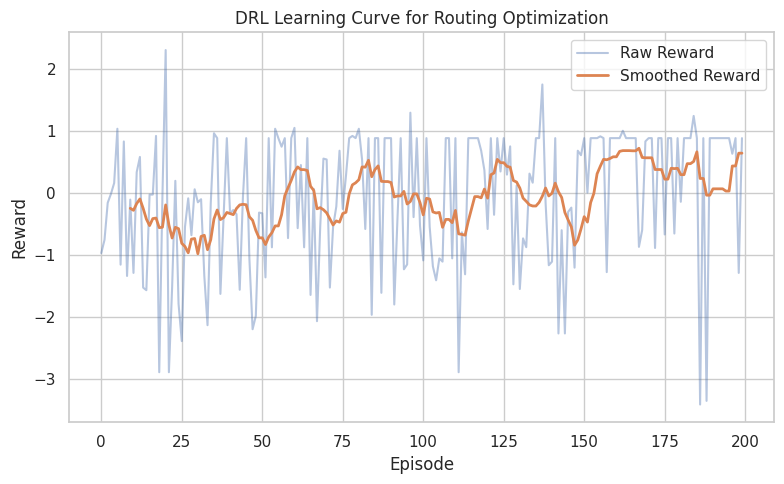

In [ ]:
# -----------------------------
# BLOCK 6: Learning Visualization
# -----------------------------

import matplotlib.pyplot as plt
import numpy as np

# Smooth rewards for clarity
window = 10
smoothed_rewards = np.convolve(
    reward_history,
    np.ones(window)/window,
    mode="valid"
)

plt.figure(figsize=(8,5))
plt.plot(reward_history, alpha=0.4, label="Raw Reward")
plt.plot(
    range(window-1, len(smoothed_rewards)+window-1),
    smoothed_rewards,
    linewidth=2,
    label="Smoothed Reward"
)

plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("DRL Learning Curve for Routing Optimization")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Traditional routing AVERAGE reward: -0.5130205658412559
DRL routing AVERAGE reward (learned): 0.4300525096831416


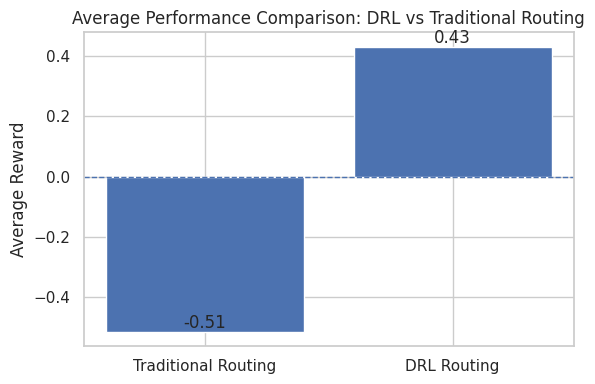

In [ ]:
# -----------------------------
# BLOCK 7.5: Fair Comparison
# -----------------------------

# Traditional routing: average reward over all routes
traditional_rewards_all = df_scaled.apply(compute_reward, axis=1)
traditional_avg_reward = traditional_rewards_all.mean()

# DRL routing: use top learned actions (last 50 episodes)
drl_avg_reward = np.mean(reward_history[-50:])

print("Traditional routing AVERAGE reward:", traditional_avg_reward)
print("DRL routing AVERAGE reward (learned):", drl_avg_reward)

# -----------------------------
# FINAL VISUAL COMPARISON
# -----------------------------

methods = ["Traditional Routing", "DRL Routing"]
avg_rewards = [traditional_avg_reward, drl_avg_reward]

plt.figure(figsize=(6,4))
bars = plt.bar(methods, avg_rewards)

plt.axhline(0, linestyle="--", linewidth=1)
plt.ylabel("Average Reward")
plt.title("Average Performance Comparison: DRL vs Traditional Routing")

# Annotate values on bars
for bar in bars:
    yval = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,
        yval,
        f"{yval:.2f}",
        ha="center",
        va="bottom"
    )

plt.tight_layout()
plt.show()



In [ ]:
# -----------------------------
# BLOCK 8: Best Route by DRL
# -----------------------------

# Use trained model to score all routes
model.eval()

with torch.no_grad():
    all_states = torch.tensor(
        df_scaled[state_features].values,
        dtype=torch.float32
    ).to(device)

    q_values = model(all_states)
    best_action = torch.argmax(q_values.mean(dim=0)).item()

best_drl_route = df.loc[best_action]

print("Best route selected by DRL:")
print(best_drl_route)

print("\nReward of DRL-selected route:")
print(compute_reward(df_scaled.loc[best_action]))


Best route selected by DRL:
Route_ID                         R245
Source_Node                         8
Destination_Node                   26
Latency_ms                  62.207759
Bandwidth_Mbps              70.253826
Security_Risk                0.152104
Energy_Consumption_J         2.815139
Packet_Delivery_Ratio_%     97.549401
End_to_End_Delay_ms          8.915775
Trust_Score                  0.340959
Algorithm_Used             MCRO-RHGSO
Optimal                             0
Name: 244, dtype: object

Reward of DRL-selected route:
0.8835947445594075
